In [1]:
from math import pi
import numpy as np
import matplotlib.pyplot as plt
import wavio
from scipy import fftpack, signal
import IPython

during the initialization stage of nlms filter, we should set each weight of FIR taps into a random value in order to seek a convergence result from iteration.

In [2]:
def nlms(un, dn, M, mu):
    """
    :param un: unknow signal
    :type  un: numpy.ndarray
    :param dn: expectation signal
    :type  dn: numpy.ndarray
    :param M : length of FIR filter
    :type  M : int
    :param mu: learning rate
    :type  mu: float
    :return: yn, en
    """
    # To ensure the length of un and dn is same
    ITER = min(len(un),len(dn)) 
    
    # Signal buffer
    u = np.zeros(M)
    
    # FIR Weights
    w = np.random.normal(0, 0.4, M)
    
    # Estimated Signal, FIR Product
    yn = np.zeros(ITER) 
    
    # Error Signal, difference between estimation and expectation
    en = np.zeros(ITER) 
    
    for n in range(ITER):
        u[1:M] = u[0:M-1]
        u[0] = un[n]
        yn[n] = np.dot(w.T, u)
        en[n] = dn[n] - yn[n]
        w = w + mu * en[n] * u / (np.dot(u, u) + 1e-7)
    return yn, en, w

In [3]:
white = wavio.read("white_noise.wav")
white = white.data[:, 0]
white = white.astype(np.float32, order='C') / 32767.0

tele = wavio.read("tele_noise.wav")
tele = tele.data[:, 0]
tele = tele.astype(np.float32, order='C') / 32767.0
delay = 256
tele = np.append(np.zeros(delay), tele)[:-delay]

White noise is generated by Audacity, amplitude in 0.8, after a telephone EQ curve applied whic reuslt in tele noise. We can use a optimal nlms(without interference - $v(n) = 0$, learning rate - $mu$ can be set into $1$) to observe the convergence weight of FIR taps.

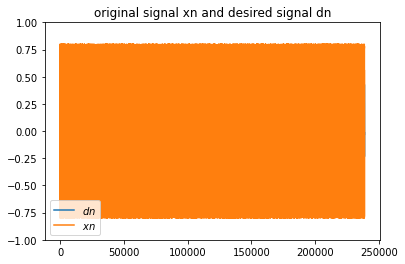

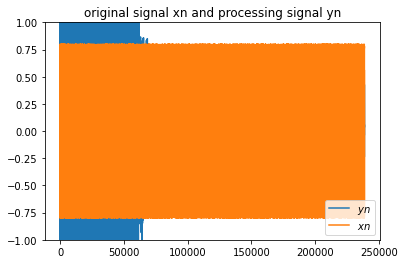

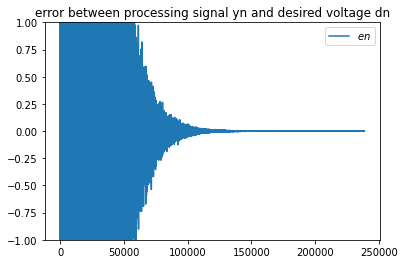

In [4]:
# FIR taps length
M = 8192
# moving steps, learning rate
mu = 1

xn = white
dn = tele

(yn, en, w) = nlms(xn, dn, M, mu)

plt.figure(1)
plt.plot(dn,label="$dn$")
plt.plot(xn,label="$xn$")
plt.ylim(-1, 1)
plt.title("original signal xn and desired signal dn")
plt.legend() 

plt.figure(2)
plt.plot(yn,label="$yn$")
plt.plot(xn,label="$xn$")
plt.ylim(-1, 1)
plt.title("original signal xn and processing signal yn")
plt.legend()
    
plt.figure(3)
plt.plot(en,label="$en$")
plt.ylim(-1, 1)
plt.title("error between processing signal yn and desired voltage dn")
plt.legend()

plt.show()

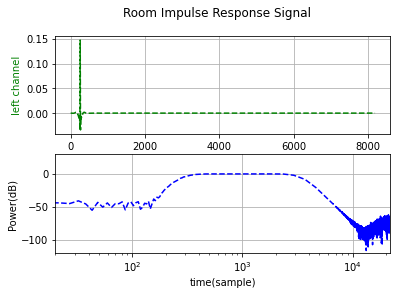

In [5]:
sr = 44100
weight = w

x_axis = np.arange(len(weight))

plt.figure(1)
plt.suptitle('Room Impulse Response Signal')

plt.subplot(211)
plt.plot(x_axis, weight, 'g--')
plt.ylabel('left channel', color='g')
plt.grid()

weight_time = np.arange(len(weight))*1.0/sr
weight_power = 20*np.log10(np.abs(np.fft.rfft(weight)))
weight_frequency = np.linspace(0, sr/2.0, len(weight_power))

plt.subplot(212)
plt.plot(weight_frequency, weight_power, 'b--')
plt.ylabel("Power(dB)")
plt.xlabel(r'time(sample)')
plt.xscale('log')
plt.ylim(-120, 30)
plt.xlim(20, 22000)
plt.grid()

plt.show()

Move previous experiment a step forward, apply a IIR biquad filter to white noise, we can convert this product back to frequency response(stable FIR coefficient) by nlms algorithm.

- filter type = low-pass2
- fc = 1500
- fs = 44100
- Q = 0.5
- magnitude = 0

In [6]:
numerator = [0.009384613070353884, 0.01876922614070777, 0.009384613070353884]
denominator = [1.0, -1.6125031495280742, 0.6500416018094897]
low_pass_output = signal.lfilter(numerator, denominator, white)

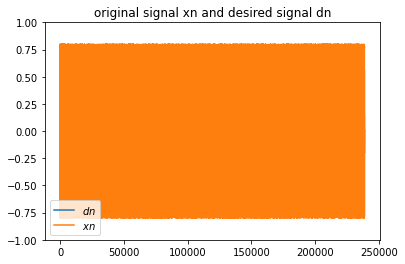

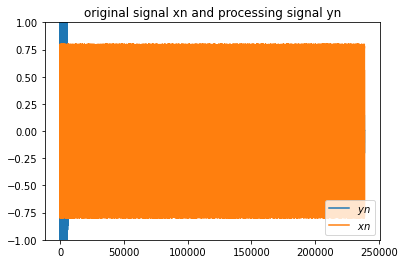

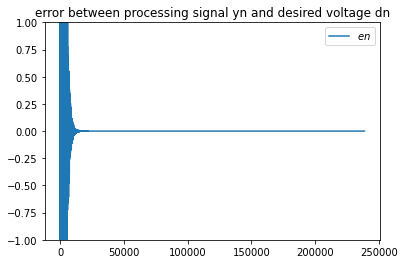

In [7]:
# FIR taps length
M = 1024
# moving steps, learning rate
mu = 1

xn = white
dn = low_pass_output

(yn, en, w) = nlms(xn, dn, M, mu)

plt.figure(1)
plt.plot(dn,label="$dn$")
plt.plot(xn,label="$xn$")
plt.ylim(-1, 1)
plt.title("original signal xn and desired signal dn")
plt.legend() 

plt.figure(2)
plt.plot(yn,label="$yn$")
plt.plot(xn,label="$xn$")
plt.ylim(-1, 1)
plt.title("original signal xn and processing signal yn")
plt.legend()
    
plt.figure(3)
plt.plot(en,label="$en$")
plt.ylim(-1, 1)
plt.title("error between processing signal yn and desired voltage dn")
plt.legend()

plt.show()

C:\Users\Lava.kweiwen\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


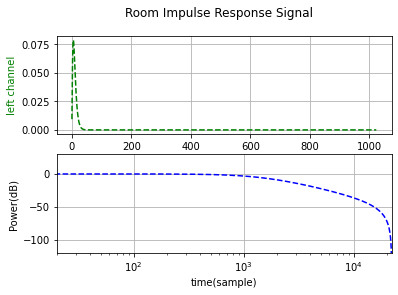

In [8]:
sr = 44100
weight = w

x_axis = np.arange(len(weight))

plt.figure(1)
plt.suptitle('Room Impulse Response Signal')

plt.subplot(211)
plt.plot(x_axis, weight, 'g--')
plt.ylabel('left channel', color='g')
plt.grid()

weight_time = np.arange(len(weight))*1.0/sr
weight_power = 20*np.log10(np.abs(np.fft.rfft(weight)))
weight_frequency = np.linspace(0, sr/2.0, len(weight_power))

plt.subplot(212)
plt.plot(weight_frequency, weight_power, 'b--')
plt.ylabel("Power(dB)")
plt.xlabel(r'time(sample)')
plt.xscale('log')
plt.ylim(-120, 30)
plt.xlim(20, 22000)
plt.grid()

plt.show()

Move previous experiment a step forward, apply a real room impulse response onto white noise, we can convert this product back to frequency response(stable FIR coefficient) by nlms algorithm.

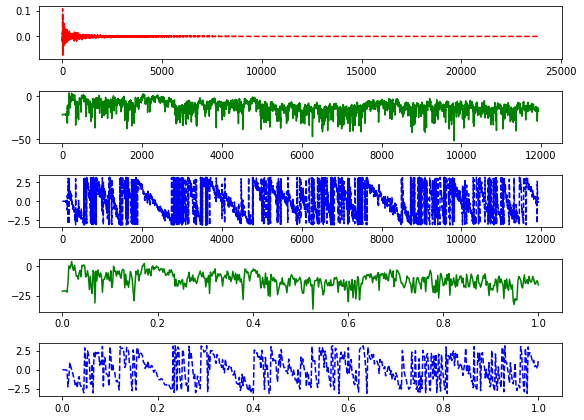

In [9]:
sr = 44100

wav = wavio.read("large_choir_hall.wav")

left_channel = wav.data[:, 0]
left_channel = left_channel.astype(np.float32, order='C') / 32767.0
left_channel = signal.decimate(x=left_channel, q = 10, ftype='fir')

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 6))
fig.tight_layout()

plt.subplot(511)
plt.plot(left_channel, 'r--')

# using rfft to generate frequency response and phase response
left_time = np.arange(len(left_channel))*1.0/sr
left_magnitude = 20*np.log10(np.abs(np.fft.rfft(left_channel)))
left_phase = np.angle(np.fft.rfft(left_channel))

plt.subplot(512)
plt.plot(left_magnitude, 'g')

plt.subplot(513)
plt.plot(left_phase, 'b--')

# using freqz to generate frequency response and phase response
w, h = signal.freqz(left_channel)
amplitude = 20 * np.log10(abs(h))
angle = np.angle(h)

plt.subplot(514)
plt.plot(w/max(w), amplitude, 'g')

plt.subplot(515)
plt.plot(w/max(w), angle, 'b--')

plt.show()

convolve white noise and room impulse response, use filter approach.
(i don't know why "fft convolve" will lead a non-convergence result in nlms, why "fft convolve" isn't working here?) 

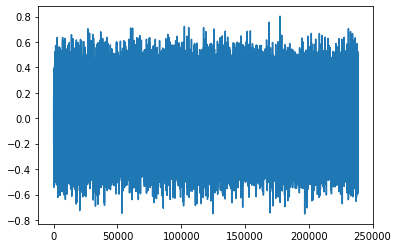

In [10]:
convolution_output = signal.lfilter(left_channel, 1, white)
plt.plot(convolution_output)

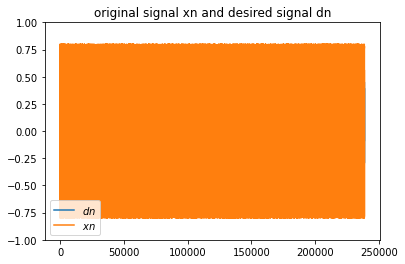

In [ ]:
# FIR taps length
M = 8192
# moving steps, learning rate
mu = 1

xn = white
dn = convolution_output 

(yn, en, w) = nlms(xn, dn, M, mu)

plt.figure(1)
plt.plot(dn,label="$dn$")
plt.plot(xn,label="$xn$")
plt.ylim(-1, 1)
plt.title("original signal xn and desired signal dn")
plt.legend() 

plt.figure(2)
plt.plot(yn,label="$yn$")
plt.plot(xn,label="$xn$")
plt.ylim(-1, 1)
plt.title("original signal xn and processing signal yn")
plt.legend()
    
plt.figure(3)
plt.plot(en,label="$en$")
plt.ylim(-1, 1)
plt.title("error between processing signal yn and desired voltage dn")
plt.legend()

plt.show()

In [ ]:
sr = 44100
weight = w

x_axis = np.arange(len(weight))

plt.figure(1)
plt.suptitle('Room Impulse Response Signal - derive by nlms approach')

plt.subplot(211)
plt.plot(x_axis, weight, 'g--')
plt.ylabel('left channel', color='g')
plt.grid()

weight_time = np.arange(len(weight))*1.0/sr
weight_power = 20*np.log10(np.abs(np.fft.rfft(weight)))
weight_frequency = np.linspace(0, sr/2.0, len(weight_power))

plt.subplot(212)
plt.plot(weight_frequency, weight_power, 'b--')
plt.ylabel("Power(dB)")
plt.xlabel(r'time(sample)')
plt.xscale('log')
plt.ylim(-120, 30)
plt.xlim(20, 22000)
plt.grid()

plt.show()